<font size = 5><b>BoA Classification</b></font><br>
I think we need as inputs for this notebook:
 - The original training and test sets (maybe)
 - Sparse encodings for the training set, patch-level
 - Sparse encodings for the test set, patch-level
 
 The last 2 should come from the same dictionary, and use the same encoding params (I think)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib import cm
import matplotlib as m
import pylab as pl

import numpy as np
import time
import os
import sys
import math
import pickle
import pandas as pd
import csv
from __future__ import division
import itertools

from skimage import io, filters, util, data, img_as_float
import scipy
import brewer2mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, sparse_encode, PCA
from sklearn.feature_extraction.image import extract_patches_2d, PatchExtractor, reconstruct_from_patches_2d
from sklearn.manifold import TSNE
from skimage.transform import downscale_local_mean
from sklearn.metrics import confusion_matrix

import skynet.pipeline
import skynet.utils
import skynet.dl_utils as dl
import skynet.viz as viz

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram, leaves_list

data_path = "/Users/don/Documents/patch_data/"
dl_path = "/Users/don/Documents/DL/"

#Tell numpy to skip division by zero in broadcasting
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [4]:
def get_binary_matrix(X, method):
    """Gets the absolute value of all nonzero entries in X
    That is: X_b[i, j] == L-p|X[i,j]|
    The L-p norm depends on the parameter 'method'
    
    PARAMS
    X: 2D array
    method: str; l0 or l1.
    
    RETURNS
    X_b: array of the same shape as X
    """
    X_b = np.zeros_like(X)
    for i in range(len(X)):
        for j in range(len(X[i])):
            if method == 'l0':
                if X[i][j] != 0:
                    X_b[i][j] = 1
            elif method == 'l1':
                X_b[i][j] = abs(X[i][j])
    
    return X_b


def term_freq(X, method='raw'):
    """Compute frequency of each patch in each image. Due to the way you set up the data structure,
    if method='raw', this just returns X.
    """
    if method == 'log':
        tf = np.zeros_like(X)
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j] != 0:
                    tf[i][j] = 1+math.log(X[i][j])
    elif method == 'raw':
        tf = X
        
    return tf

def inverse_doc_freq(X, N, method='raw'):
    """Computes the inverse document frequency for each term (atom)
    That is: atoms that are universally used across all documents (images)
    are not as interesting (i.e. stop words), so we diminish their weights. 
    """
    idf = np.zeros(X.shape[1])
    for i in range(len(X.T)):
        term = X.T[i]
        n_t = 0 # no. of docs which term appears in
        for d in term:
            if d > 0:
                n_t +=1

        if n_t == 0:
            idf[i] = 0
        else:
            if method == 'log':
                idf[i] = math.log(N/n_t)
            elif method == 'raw':
                idf[i] = N/n_t
    
    return np.diag(idf)

File formats for sparse vector dataframes:
 - sps\_dict fn: dict name\_encoding algo
 - sps_dict cols: 1, 2, 4, 8, 16, 32, 64, img_idx, moa

In [12]:
# Load the patch-level sparse vecs
dict_encoding_fn = 'V46a1e-1_lars'
mydata = np.load(data_path+dict_encoding_fn+'.p')
sps_tr = mydata[0]
sps_te = mydata[1]
err_dict = mydata[2]
print(sps_tr.shape)
print(sps_te.shape)

(19200, 10)
(4800, 10)


In [13]:
err_dict['tr_err']

{1: [2.6324880237322708, 0.16395053856364936, 52.550450442472581],
 2: [3.9516189081853796, 0.26602997890779712, 65.241710586234333],
 4: [5.183969905031371, 0.38246461462866627, 70.621726400695522],
 8: [7.665650173123427, 0.62531330456457979, 62.857552020834788],
 16: [9.2862804052621879, 1.030355339130812, 49.866410449381718],
 32: [11.670877894799855, 1.6878601870072063, 19.691574474145849]}

In [14]:
err_dict['te_err']

{1: [1.9172040881137695, 0.066892278677239417, 53.15957191805682],
 2: [4.0848367226488822, 0.15349361069531081, 65.806394184132515],
 4: [5.7249905902464695, 0.29315558801206359, 70.643067494610349],
 8: [9.1073866874779892, 0.56149513785448657, 62.311178048218316],
 16: [11.779009499465412, 0.98573475739953187, 48.538167491356354],
 32: [13.262714892559792, 1.6530588105294972, 19.50533861072233]}

In [17]:
# Now get the image-level dictionaries for training and test sets
bin_method = 'l1'
alpha_ls = [1,2,4,8,16,32]
sps_im_dict = {1:[],2:[],4:[],8:[],16:[],32:[],
               'moa':[], 'img_idx':[]}
img_idx_ref = list(set(sps_tr['img_idx']))

for idx in img_idx_ref:
    d_temp = sps_tr.loc[sps_tr['img_idx'] == idx]
    
    for alpha in alpha_ls:
        patch_data = np.array(list(d_temp[alpha]))
        # Images are just the np.ave of patch data
        patch_data_b = get_binary_matrix(patch_data, method=bin_method)
        img_vec = np.average(patch_data_b, axis=0)
        sps_im_dict[alpha].append(img_vec)
    
    moa = list(d_temp['moa'])[0]
    sps_im_dict['moa'].append(moa)
    sps_im_dict['img_idx'].append(idx)

sps_im_tr = pd.DataFrame(sps_im_dict)

# Test set ======================================================
sps_im_dict = {1:[],2:[],4:[],8:[],16:[],32:[],
               'moa':[], 'img_idx':[]}
img_idx_ref = list(set(sps_te['img_idx']))

for idx in img_idx_ref:
    d_temp = sps_te.loc[sps_te['img_idx'] == idx]
    
    for alpha in alpha_ls:
        patch_data = np.array(list(d_temp[alpha]))
        patch_data_b = get_binary_matrix(patch_data, method=bin_method)
        img_vec = np.average(patch_data_b, axis=0)
        sps_im_dict[alpha].append(img_vec)
    
    moa = list(d_temp['moa'])[0]
    sps_im_dict['moa'].append(moa)
    sps_im_dict['img_idx'].append(idx)

sps_im_te = pd.DataFrame(sps_im_dict)
print(sps_im_te.shape)

(24, 8)


<font size = 5><b>TF-IDF</b></font><br><br>
In conventional word processing, TF-IDF is the relative importance of a word to a document, out of a collection of documents. 
We can do this for the atoms themselves, to to measure how important each atom is to each image, or MOA.

Equivalents:
 - Term = atom
 - Document = Image
 - Topic = MOA
 - Frequency = I'm using an l1-binary matrix, so this will refer to the coefficient values in each sparse representation. When aggregated to image-level, each image is the np.sum of all its patches.
 
Note that we set atoms that are unused to 0, instead of removing them completely. This is necessary because atoms unused in training may still be used in the testing set. 

All the notations:
 - N = Total no. of documents in the collection
 - F_t = no. of documents where term <i>t</i> appears. Stored in array F, shape (n_terms,) = (n_atoms,)
 - f_t,d = no. of times term <i>t</i> appears in doc <i>d</i>. Stored as array f_td, shape(n_docs, n_terms) = (n_imgs, n_atoms)
 
<b>Some Observations</b><br>
- For both OMP and LARs as encoding algorithms, different classes show different banding patterns, though it's not clear how these differ. It could be that Class A and class B use roughly the same atoms, but class A's coefficients are larger in general than class B. 
- In general, the log transform diminishes large changes, since the log-curve tapers off as x --> infinity. We don't always want this because large changes that may distinguish a class is exactly what we're looking for in terms of class separability. However, if only one image in some class uses atom j very highly, it could unduly distort class-representation as an outlier. We won't really be able to resolve this since there's only 10 images per class, so adjusting the whole algorithm based on just one occurence is still an overly punitive measure. Overall, log-transforms don't seem to do us any favours, so we stick to raw frequencies.

In [18]:
alfa=1
d0 = sps_im_tr[[alfa, 'img_idx', 'moa']]
d0_te = sps_im_te[[alfa, 'img_idx', 'moa']]
d0 = d0.sort_values(by='moa')
d0_te = d0_te.sort_values(by='moa')

labels = list(set(d0['moa']))

X1 = np.array(list(d0[alfa]))
X2 = np.array(list(d0_te[alfa]))
print(X1.shape, X2.shape)

(96, 300) (24, 300)


In [19]:
N = len(d0)

tf_1 = term_freq(X1, method='raw')
idf_1 = inverse_doc_freq(X1, N, method='raw')
tfidf_1 = tf_1 @ idf_1

tf_2 = term_freq(X2, method='raw')
idf_2 = inverse_doc_freq(X2, N, method='raw')
tfidf_2 = tf_2 @ idf_2

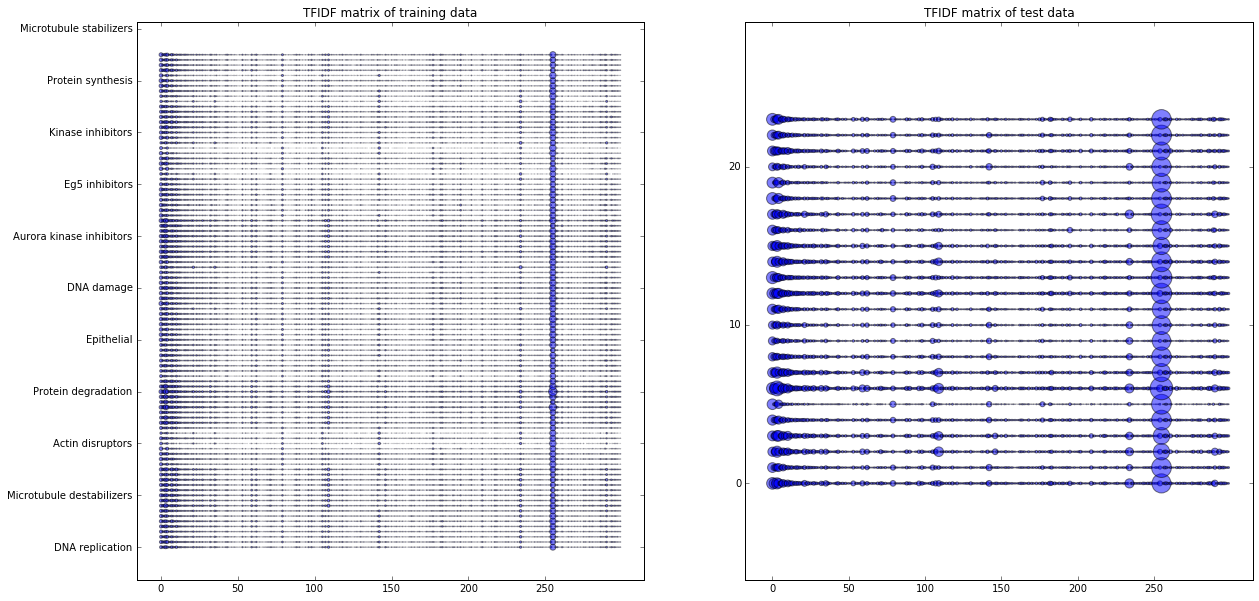

In [20]:
plt.figure(figsize=(20,10))
r, c = np.nonzero(tfidf_1)
y_rng = np.arange(0, tfidf_1.shape[1], 10)

plt.subplot(1,2,1)
plt.xticks(np.arange(0, tfidf_1.shape[1], 50))
plt.yticks(y_rng, labels)
plt.title("TFIDF matrix of training data")
plt.scatter(c, r, marker='o', alpha=0.5, s=tfidf_1[r, c]*2)

r, c = np.nonzero(tfidf_2)

plt.subplot(1,2,2)
plt.xticks(np.arange(0, tfidf_2.shape[1], 50))
plt.yticks(y_rng)
plt.title("TFIDF matrix of test data")
plt.scatter(c, r, marker='o', alpha=0.5, s=tfidf_2[r, c]*5)


<font size = 5><b>Logistic Regression</b></font>
<br>The best alpha is usually 8 or 16, depending on the run. That is: different sparse encodings of the <i>training set</i> could yield such different values of alpha for which classification accuracy is maximized, while dfferent sparse encodings of the <i>test set</i>, given the <i>same training set</i>, doesn't tend to yield as much variability. The TFIDF matrix is directly transformed from the sparse encoding matrix of the training data, after all. 

Altogether, LARS is superior to OMP in sparse encoding, both in terms of reconstruction error and subsequent LogRegression classification accuracy. LARS yields values like 52.5%, 48.33%, etc., whereas OMP can barely beat 40%. 

Also, the max-classification value of alpha isn't the lowest anything - not Euclidean reconstruction error, not objective function loss. The only link is that 16 is the the alpha parameter originally used to train the dictionary V40o, but the algorithm used in training was OMP, not LARS.

In [21]:
from sklearn.linear_model import LogisticRegression

y_str_tr = list(d0['moa'])
y_ref = list(set(y_str_tr))
y_ref.sort()
y_tr = skynet.utils.my_one_hot_index(y_str_tr, y_ref)

y_str_te = list(d0_te['moa'])
y_te = skynet.utils.my_one_hot_index(y_str_te, y_ref)

x_tr = list(tfidf_1)
x_te = list(tfidf_2)

print("No. of training images (len(y_tr)) = %s" % len(y_tr))
print("No. of test images (len(y_te)) = %s" % len(y_te))

No. of training images (len(y_tr)) = 96
No. of test images (len(y_te)) = 24


In [22]:
loggy = LogisticRegression()
loggy_fit = loggy.fit(x_tr, y_tr)
pred = loggy_fit.predict(x_te)
results = loggy_fit.score(x_te, y_te)
print(results)

0.625


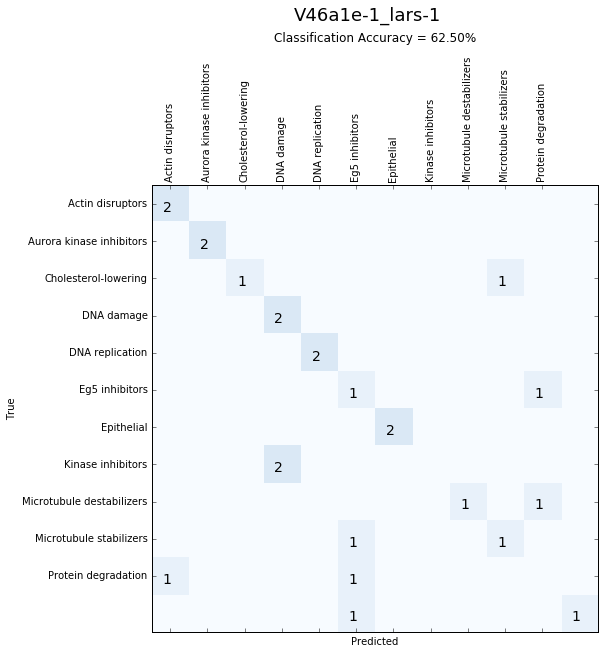

In [23]:
C = confusion_matrix(y_te, pred)
# C(i, j) := no. of obs in group i but predicted to be in j.

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax_ls = ax.get_xticks().tolist()
#for i in range(len(ax_ls)):
#    ax_ls[i] = y_ref[i]

#ax.set_xticks(np.arange(11))
#ax.set_xticklabels(['']+y_ref, rotation='vertical')
#ax.set_yticklabels(['']+ax_ls)
cax = ax.matshow(C, cmap=cm.Blues, vmin=0, vmax=14)
for i, cas in enumerate(C):
    for j, c in enumerate(cas):
        if c>0:
            plt.text(j-.2, i+.2, c, fontsize=14)

#fig.colorbar(cax)
title_str = dict_encoding_fn + '-'+str(alfa)

plt.suptitle(title_str, fontsize=18, y=1.21)
plt.title("Classification Accuracy = %.2f%%" 
          % (results*100), 
         y=1.31)
plt.yticks(np.arange(11), y_ref)
plt.xticks(np.arange(11), y_ref, rotation='vertical')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<font size = 5><b>Latent Dirichlet Allocation</b></font><br><br>
This uses the "topic = MOA" parrallel directly, resulting in a more specific (but perhaps more biased) classification. Also note that conventionally, the number of topics is a hyperparameter, which need not be 12. Well, if it's not 12, that's information too.<br><br>
sklearn: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
<br>A very good youtube vid: https://www.youtube.com/watch?v=3mHy4OSyRf0

 - A topic is assigned to each word, making a document a mixture of topics. Formally: a document is a pdf over topics; a topic is a pdf over words.
 - Each (training or testing?) doc gets represented as a pattern (pdf?) of LDA topics, making every document different enough to be separable, yet similar enough to be grouped.
 - The topics don't need to have any semantic labels. You can add them if you want, but they won't (shouldn't!) have any analytical weight.
 
<b>Parameters</b>
 - Two params: alpha and beta (a and b), parameters of the dirichlet distribution. alpha controls per-document topic distribution, beta controls per-topic word distribution.
 - A high alpha would mean that documents are likely to have a large mix of topics, instead of being represented by just a few topics specifically. A high beta means that each topic is more likely to contain a mixture of more words, instead of just a few words. 
 - A high alpha makes documents "more similar" to each other; a high beta makes topics "more similar" to each other. Similarity is probably interpreted in terms of semantic overlap.
 - Tuning the number of topics is a bit of a dark art, but different possible numbers of topics will yield meaningful interpretations. If we're considering topic distribution w.r.t. classification for instance, a topic that is relatively insular, and keeps appearing regardless of the number of topics, means that that topic is very well-defined. 
 - A fitted LDA model will only understand the words that have been used to train the model; new, unencountered words in the test set might as well not be there. This may serve well in text mining because of the sheer number of words.
 
<b>Not Sure How This Fits In</b>
- We can measure distance using Jensen-Shannon distance, a standard way to measure difference between 2 pdfs.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda0 = LDA(10)
print(tfidf_1.shape)
lda0.fit(tfidf_1)

In [ ]:
watsthis = lda0.components_

plt.figure(figsize=(14,7))
r, c = np.nonzero(watsthis)
plt.scatter(c, r, marker='o', alpha=0.5, s=watsthis[r, c]*0.1)

In [ ]:
watsdis2 = lda0.transform(tfidf_1)
print(watsdis2.shape)

plt.figure(figsize=(14,7))
r, c = np.nonzero(watsdis2)
plt.scatter(c, r, marker='o', alpha=0.5, s=watsdis2[r, c]*0.1)